# Demo plan: 3-version N-version head/helmet detector

## 1. Setup & data (Cells 1–3)

**What we run**

1. Mount Google Drive and set `PROJECT_ROOT`.
2. Unzip the hardhat dataset into `/content/hardhat_yolo_data/hardhat_yolo_data`.
3. Define paths to:
   - Validation images and labels
   - Prediction JSONs for each model and fusion method
   - (Optionally) the metrics CSV

**What to say**

- We work on a **2-class PPE task**:  
  - Class 0 = **head**  
  - Class 1 = **helmet**
- The dataset is the hardhat construction site dataset, converted to **YOLO format** with only *head* and *helmet* labels (we ignore the original `person` class).
- All experiments use the same train/val split; only the model architecture or fusion changes.

---

## 2. Models and N-version setup (conceptual slide / explanation)

**What we have trained**

- **YOLOv8n (seed 0)** – small, fast detector  
- **YOLOv8s (seed 0)** – slightly larger YOLO model  
- **Faster R-CNN (seed 0)** – region-based detector using ResNet-50 backbone  

All three are trained on the same **2-class head/helmet data**.

**N-version idea**

- These three detectors are our **3 “versions”**.
- We don’t trust any single model; instead we:
  1. Combine them with **Weighted Boxes Fusion (WBF)** → performance-oriented fusion.
  2. Apply a **2-out-of-3 majority vote** over clustered boxes → dependability-oriented voter.

---

## 3. Load predictions and mappings (Cells 4–7)

**What we run**

- `load_preds_by_image(...)` to load YOLO and fusion JSONs (already per-image).
- `load_frcnn_by_image(...)` to:
  - regroup Faster R-CNN detections per image,
  - map labels from `{1=head, 2=helmet}` → `{0=head, 1=helmet}`,
  - normalize boxes to `[0,1]`.
- Build image index mappings:
  - `IDX_TO_STEM`, `STEM_TO_IDX`
  - `STEM_TO_SIZE` for image width/height

**What to say**

- All predictions are unified into the **same format**:
  - normalized `xyxy` boxes,
  - scores,
  - labels in `{0=head, 1=helmet}`.
- This common representation makes it easy to visualize and fuse outputs from different models.

---

## 4. Qualitative N-version visualization (Cells 8–9)

**What we run**

- `show_all_methods_for_image(stem, score_thresh=0.4)`  
  Example stems you can use in the demo:
  - `hard_hat_workers801`
  - `hard_hat_workers830`
  - `hard_hat_workers852`
  - `hard_hat_workers475`
  - `hard_hat_workers863`

Each call shows **6 panels**:

1. YOLOv8n
2. YOLOv8s
3. Faster R-CNN
4. WBF (YOLOv8n + YOLOv8s)
5. WBF (YOLOv8n + YOLOv8s + Faster R-CNN)
6. 2-out-of-3 majority vote

**What to say while showing an example**

- Point out that **each row is one image**, each column is a different system output.
- Highlight where models **disagree**:
  - YOLO sometimes misses tiny heads or has fewer false positives.
  - Faster R-CNN often has **higher recall** but more false positives.
- Show how **WBF** tends to keep most detections (good recall) but can accept boxes even if only one model fired.
- Show how the **2-out-of-3 voter** is more conservative:
  - It only keeps boxes where **at least two models agree** on location + class.
  - This removes some false positives but can drop borderline detections.

Phrase to use:

> “This panel is our N-version system in action: three independent detectors, a performance-oriented fusion (WBF), and a dependability-oriented 2-out-of-3 voter.”

---

## 5. Quantitative comparison: base models vs fusion

**What we run**

- The bar chart that uses the metrics CSV to plot **mAP@0.5** for:
  - YOLOv8n_seed0_clean  
  - YOLOv8s_seed0_clean  
  - FasterRCNN_seed0  
  - WBF_yolov8n_yolov8s_clean  
  - WBF_yolov8n_yolov8s_frcnn_clean  
  - MajorityVote_n_s_frcnn_clean

**What to say**

- All methods are evaluated on the same 1000-image val set.
- Single models get mAP@0.5 around **0.90–0.92**.
- WBF (n+s) and WBF (n+s+FRCNN) slightly **improve mAP** over the best single model.
- The majority voter trades some mAP to aim for **fewer false alarms**.

---

## 6. Trade-off plot: performance vs dependability

**What we run**

- The 2-bar grouped plot comparing:
  - `WBF_yolov8n_yolov8s_frcnn_clean` (performance-oriented fusion)
  - `MajorityVote_n_s_frcnn_clean` (dependability-oriented voter)
- Metrics shown: **mAP@0.5**, **precision**, **recall**.

**What to say**

- **Fusion (WBF)**:
  - mAP@0.5 ≈ 0.92  
  - Precision ≈ 0.87  
  - Recall ≈ 0.95
- **Majority vote (2-out-of-3)**:
  - mAP@0.5 ≈ 0.89  
  - Precision ≈ 0.94  
  - Recall ≈ 0.91

Key sentence:

> “The fusion system maximizes detection performance, but the N-version **majority voter** is more dependable: it sacrifices a bit of recall to substantially increase precision by only trusting boxes where multiple models agree.”

---

## 7. Wrap-up talking points

- We built a **3-version N-version architecture** for head/helmet detection:
  - YOLOv8n, YOLOv8s, Faster R-CNN.
- We implemented **two decision mechanisms** on top:
  - Weighted Boxes Fusion (high-performance fusion).
  - 2-out-of-3 majority vote (dependability-oriented).
- We showed:
  - **Qualitative** examples where models disagree and how fusion/voting behaves.
  - **Quantitative** bar charts and trade-off plots from the same validation set.
- Safety interpretation:
  - “Head without helmet” corresponds to **PPE violations**.
  - A high-precision majority vote is attractive when false alarms are expensive, while high-recall fusion is better if missing a violation is unacceptable.

**Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Paths + unzip dataset**

In [2]:
from pathlib import Path
import os, zipfile

# Project root on Drive
PROJECT_ROOT = Path("/content/drive/MyDrive/CS6436_project")

# Dataset zip on Drive
DATA_ZIP = PROJECT_ROOT / "hardhat_yolo_data.zip"

# Where we unpack the dataset in the Colab runtime
DATA_ROOT = Path("/content/hardhat_yolo_data/hardhat_yolo_data")

# Unzip only if not already extracted
if not DATA_ROOT.exists():
    print("Extracting dataset...")
    os.makedirs("/content/hardhat_yolo_data", exist_ok=True)
    with zipfile.ZipFile(DATA_ZIP, "r") as z:
        z.extractall("/content/hardhat_yolo_data")
else:
    print("Dataset already present at", DATA_ROOT)

# Val image/label dirs
VAL_IMAGES_DIR = DATA_ROOT / "val" / "images"
VAL_LABELS_DIR = DATA_ROOT / "val" / "labels"

print("DATA_ROOT      :", DATA_ROOT)
print("VAL_IMAGES_DIR :", VAL_IMAGES_DIR)
print("VAL_LABELS_DIR :", VAL_LABELS_DIR)

Extracting dataset...
DATA_ROOT      : /content/hardhat_yolo_data/hardhat_yolo_data
VAL_IMAGES_DIR : /content/hardhat_yolo_data/hardhat_yolo_data/val/images
VAL_LABELS_DIR : /content/hardhat_yolo_data/hardhat_yolo_data/val/labels


**JSON paths + existence check**

In [3]:
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/CS6436_project")

# Prediction JSONs (Phase 0 + Phase 1)
PREDS_YOLOV8N_VAL      = PROJECT_ROOT / "preds_yolov8n_seed0_val.json"
PREDS_YOLOV8S_VAL      = PROJECT_ROOT / "preds_yolov8s_seed0_val.json"
PREDS_FRCNN_VAL        = PROJECT_ROOT / "preds_frcnn_seed0_val.json"

PREDS_WBF_NS_VAL       = PROJECT_ROOT / "preds_wbf_yolov8n_yolov8s_val.json"
PREDS_WBF_NSF_VAL      = PROJECT_ROOT / "preds_wbf_yolov8n_yolov8s_frcnn_val.json"
PREDS_MAJ_NSF_VAL      = PROJECT_ROOT / "preds_majority_yolov8n_yolov8s_frcnn_val.json"

for p in [
    PREDS_YOLOV8N_VAL,
    PREDS_YOLOV8S_VAL,
    PREDS_FRCNN_VAL,
    PREDS_WBF_NS_VAL,
    PREDS_WBF_NSF_VAL,
    PREDS_MAJ_NSF_VAL,
]:
    print(f"{p.name:45} ->", "OK" if p.exists() else "MISSING")

preds_yolov8n_seed0_val.json                  -> OK
preds_yolov8s_seed0_val.json                  -> OK
preds_frcnn_seed0_val.json                    -> OK
preds_wbf_yolov8n_yolov8s_val.json            -> OK
preds_wbf_yolov8n_yolov8s_frcnn_val.json      -> OK
preds_majority_yolov8n_yolov8s_frcnn_val.json -> OK


**Build image lists + mappings**

In [4]:
from PIL import Image

# All val image paths
VAL_IMAGE_PATHS = sorted(VAL_IMAGES_DIR.glob("*.png"))

# Index <-> filename stem mappings
IDX_TO_STEM = {i: p.stem for i, p in enumerate(VAL_IMAGE_PATHS)}
STEM_TO_IDX = {p.stem: i for i, p in enumerate(VAL_IMAGE_PATHS)}

# Stem -> (width, height)
STEM_TO_SIZE = {}
for p in VAL_IMAGE_PATHS:
    with Image.open(p) as im:
        w, h = im.size
    STEM_TO_SIZE[p.stem] = (w, h)

print("Example mapping:", list(IDX_TO_STEM.items())[:5])

Example mapping: [(0, 'hard_hat_workers0'), (1, 'hard_hat_workers1'), (2, 'hard_hat_workers10'), (3, 'hard_hat_workers1005'), (4, 'hard_hat_workers1008')]


**Loaders for YOLO JSONs + FRCNN JSON**

In [5]:
import json
import numpy as np
from pathlib import Path

# --- For YOLO + fusion JSONs (already per-image) ---
def load_preds_by_image(json_path: Path):
    with open(json_path, "r") as f:
        records = json.load(f)

    by_image = {}
    skipped = 0

    for r in records:
        # make sure it's a dict with what we need
        if not isinstance(r, dict):
            skipped += 1
            continue

        if not all(k in r for k in ("image_id", "boxes", "scores", "labels")):
            skipped += 1
            continue

        img_id = str(r["image_id"])  # e.g. "hard_hat_workers123"
        by_image[img_id] = {
            "boxes":  np.array(r["boxes"],  dtype=float),  # normalized [0,1] xyxy
            "scores": np.array(r["scores"], dtype=float),
            "labels": np.array(r["labels"], dtype=int),    # 0=head, 1=helmet
        }

    print(f"{json_path.name}: loaded {len(by_image)} images, skipped {skipped} entries")
    return by_image


# --- For Faster R-CNN JSON (per detection -> group per image) ---
def load_frcnn_by_image(json_path: Path):
    """
    Load Faster R-CNN predictions stored per-detection and group them per image.

    Expected record format:
        {
            "image_id": 123 or "hard_hat_workers123",
            "bbox": [x, y, w, h],   # COCO xywh in *pixels*
            "score": 0.93,
            "label": 1 or 2         # 1=head, 2=helmet in FRCNN space
        }
    """
    with open(json_path, "r") as f:
        records = json.load(f)

    by_image = {}
    skipped = 0

    for r in records:
        if not isinstance(r, dict) or "image_id" not in r:
            skipped += 1
            continue

        # ---- map image_id -> filename stem ----
        raw_id = r["image_id"]
        if isinstance(raw_id, (list, tuple)):
            raw_id = raw_id[0]

        try:
            idx = int(raw_id)
            stem = IDX_TO_STEM[idx]          # e.g. 830 -> "hard_hat_workers830"
        except (ValueError, KeyError):
            stem = str(raw_id)               # already a stem

        # ---- box: COCO [x, y, w, h] -> xyxy ----
        box = r.get("bbox", r.get("boxes", None))
        if box is None or len(box) < 4:
            skipped += 1
            continue

        x, y, bw, bh = box[:4]
        x1 = x
        y1 = y
        x2 = x + bw
        y2 = y + bh
        box_xyxy = [x1, y1, x2, y2]

        # ---- score ----
        score = r.get("score", r.get("scores", None))
        if score is None:
            skipped += 1
            continue

        # ---- label ----
        label = r.get("label", r.get("labels", r.get("category_id", None)))
        if label is None:
            skipped += 1
            continue

        try:
            label_int = int(label)
        except Exception:
            skipped += 1
            continue

        # Our FRCNN JSON already uses 0=head, 1=helmet.
        # If we ever see larger labels (1,2 or 2,3 style),
        # map them down to 0/1; otherwise keep as-is.
        if label_int <= 1:
            # labels are already 0 or 1 -> use directly
            yolo_label = label_int
        else:
            # e.g. 1/2 or 2/3 -> shift down by 1
            yolo_label = label_int - 1

        d = by_image.setdefault(stem, {"boxes": [], "scores": [], "labels": []})
        d["boxes"].append(box_xyxy)
        d["scores"].append(float(score))
        d["labels"].append(yolo_label)

    # ---- convert to numpy + NORMALIZE to [0,1] ----
    for stem, d in by_image.items():
        boxes = np.array(d["boxes"], dtype=float)
        scores = np.array(d["scores"], dtype=float)
        labels = np.array(d["labels"], dtype=int)

        w, h = STEM_TO_SIZE[stem]

        if boxes.size > 0 and boxes.max() > 2.0:
            boxes[:, 0] /= w
            boxes[:, 2] /= w
            boxes[:, 1] /= h
            boxes[:, 3] /= h

        d["boxes"] = boxes
        d["scores"] = scores
        d["labels"] = labels

    print(f"{json_path.name}: grouped into {len(by_image)} images, skipped {skipped} rows")
    return by_image

**Load all prediction dictionaries**

In [6]:
preds_y_n     = load_preds_by_image(PREDS_YOLOV8N_VAL)
preds_y_s     = load_preds_by_image(PREDS_YOLOV8S_VAL)
preds_wbf_ns  = load_preds_by_image(PREDS_WBF_NS_VAL)
preds_wbf_nsf = load_preds_by_image(PREDS_WBF_NSF_VAL)
preds_maj_nsf = load_preds_by_image(PREDS_MAJ_NSF_VAL)

preds_frcnn   = load_frcnn_by_image(PREDS_FRCNN_VAL)

preds_yolov8n_seed0_val.json: loaded 1000 images, skipped 0 entries
preds_yolov8s_seed0_val.json: loaded 1000 images, skipped 0 entries
preds_wbf_yolov8n_yolov8s_val.json: loaded 1000 images, skipped 0 entries
preds_wbf_yolov8n_yolov8s_frcnn_val.json: loaded 1000 images, skipped 0 entries
preds_majority_yolov8n_yolov8s_frcnn_val.json: loaded 1000 images, skipped 0 entries
preds_frcnn_seed0_val.json: grouped into 999 images, skipped 0 rows


**Drawing helpers**

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 0 = head (no helmet), 1 = helmet
CLASS_NAMES = {0: "head", 1: "helmet"}

# Colors for boxes: red = head, green = helmet
CLASS_COLORS = {
    0: "red",    # head (no helmet)
    1: "green",  # helmet
}

def denorm_boxes(boxes, img_w, img_h):
    """
    Convert normalized [0,1] xyxy boxes -> pixel xyxy.
    If boxes is empty, just return it.
    """
    if boxes is None or len(boxes) == 0:
        return boxes
    boxes = boxes.copy()
    boxes[:, [0, 2]] *= img_w
    boxes[:, [1, 3]] *= img_h
    return boxes

def draw_boxes(ax, img, boxes, labels, scores=None, title=""):
    ax.imshow(img)
    ax.axis("off")
    if boxes is None or len(boxes) == 0:
        ax.set_title(title + " (no boxes)")
        return

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        label = int(labels[i])
        cls_name = CLASS_NAMES.get(label, str(label))
        color = CLASS_COLORS.get(label, "black")  # default just in case

        # text for the box
        txt = cls_name
        if scores is not None and len(scores) > i:
            txt += f" {scores[i]:.2f}"

        # rectangle with class-dependent color
        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            linewidth=1.5,
            edgecolor=color,   # <-- key change
        )
        ax.add_patch(rect)

        # label background can stay yellow (or you can also color by class)
        ax.text(
            x1,
            y1 - 2,
            txt,
            fontsize=8,
            color="black",
            bbox=dict(boxstyle="round,pad=0.2", fc="yellow", alpha=0.8),
        )

    ax.set_title(title)

**show_all_methods_for_image**

In [8]:
def show_all_methods_for_image(stem: str, score_thresh: float = 0.3):
    """
    stem: filename stem, e.g. "hard_hat_workers830"
    Shows 6 panels:
      - YOLOv8n
      - YOLOv8s
      - Faster R-CNN
      - WBF(n+s)
      - WBF(n+s+frcnn)
      - Majority vote (n,s,frcnn)
    """
    img_path = VAL_IMAGES_DIR / f"{stem}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Image not found: {img_path}")

    img = Image.open(img_path).convert("RGB")
    w, h = img.size

    def get_preds(preds_dict, name):
        if stem not in preds_dict:
            print(f"[WARN] {name}: no predictions for {stem}")
            return np.zeros((0, 4)), np.zeros((0,), int), np.zeros((0,))
        d = preds_dict[stem]
        boxes = d["boxes"]
        scores = d["scores"]
        labels = d["labels"]

        if boxes is None or len(boxes) == 0:
            return np.zeros((0, 4)), np.zeros((0,), int), np.zeros((0,))

        keep = scores >= score_thresh
        return boxes[keep], labels[keep], scores[keep]

    # YOLO + fusion: normalized -> pixel
    boxes_n, labels_n, scores_n = get_preds(preds_y_n, "YOLOv8n")
    boxes_n = denorm_boxes(boxes_n, w, h)

    boxes_s, labels_s, scores_s = get_preds(preds_y_s, "YOLOv8s")
    boxes_s = denorm_boxes(boxes_s, w, h)

    boxes_wbf_ns, labels_wbf_ns, scores_wbf_ns = get_preds(preds_wbf_ns, "WBF (n+s)")
    boxes_wbf_ns = denorm_boxes(boxes_wbf_ns, w, h)

    boxes_wbf_nsf, labels_wbf_nsf, scores_wbf_nsf = get_preds(preds_wbf_nsf, "WBF (n+s+f)")
    boxes_wbf_nsf = denorm_boxes(boxes_wbf_nsf, w, h)

    boxes_maj, labels_maj, scores_maj = get_preds(preds_maj_nsf, "Majority vote")
    boxes_maj = denorm_boxes(boxes_maj, w, h)

    # FRCNN: boxes are normalized already -> convert to pixels
    if stem in preds_frcnn:
        d_f = preds_frcnn[stem]
        scores_f = d_f["scores"]
        keep_f = scores_f >= score_thresh
        boxes_f = denorm_boxes(d_f["boxes"][keep_f], w, h)
        labels_f = d_f["labels"][keep_f]
        scores_f = scores_f[keep_f]
    else:
        print(f"[WARN] Faster R-CNN: no predictions for {stem}")
        boxes_f = np.zeros((0, 4))
        labels_f = np.zeros((0,), int)
        scores_f = np.zeros((0,))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    draw_boxes(axes[0], img, boxes_n, labels_n, scores_n, "YOLOv8n (seed 0)")
    draw_boxes(axes[1], img, boxes_s, labels_s, scores_s, "YOLOv8s (seed 0)")
    draw_boxes(axes[2], img, boxes_f, labels_f, scores_f, "Faster R-CNN (seed 0)")
    draw_boxes(axes[3], img, boxes_wbf_ns, labels_wbf_ns, scores_wbf_ns, "WBF (n+s)")
    draw_boxes(axes[4], img, boxes_wbf_nsf, labels_wbf_nsf, scores_wbf_nsf, "WBF (n+s+f)")
    draw_boxes(axes[5], img, boxes_maj, labels_maj, scores_maj, "2-out-of-3 majority vote")

    plt.tight_layout()
    plt.show()

**Run Demo images**

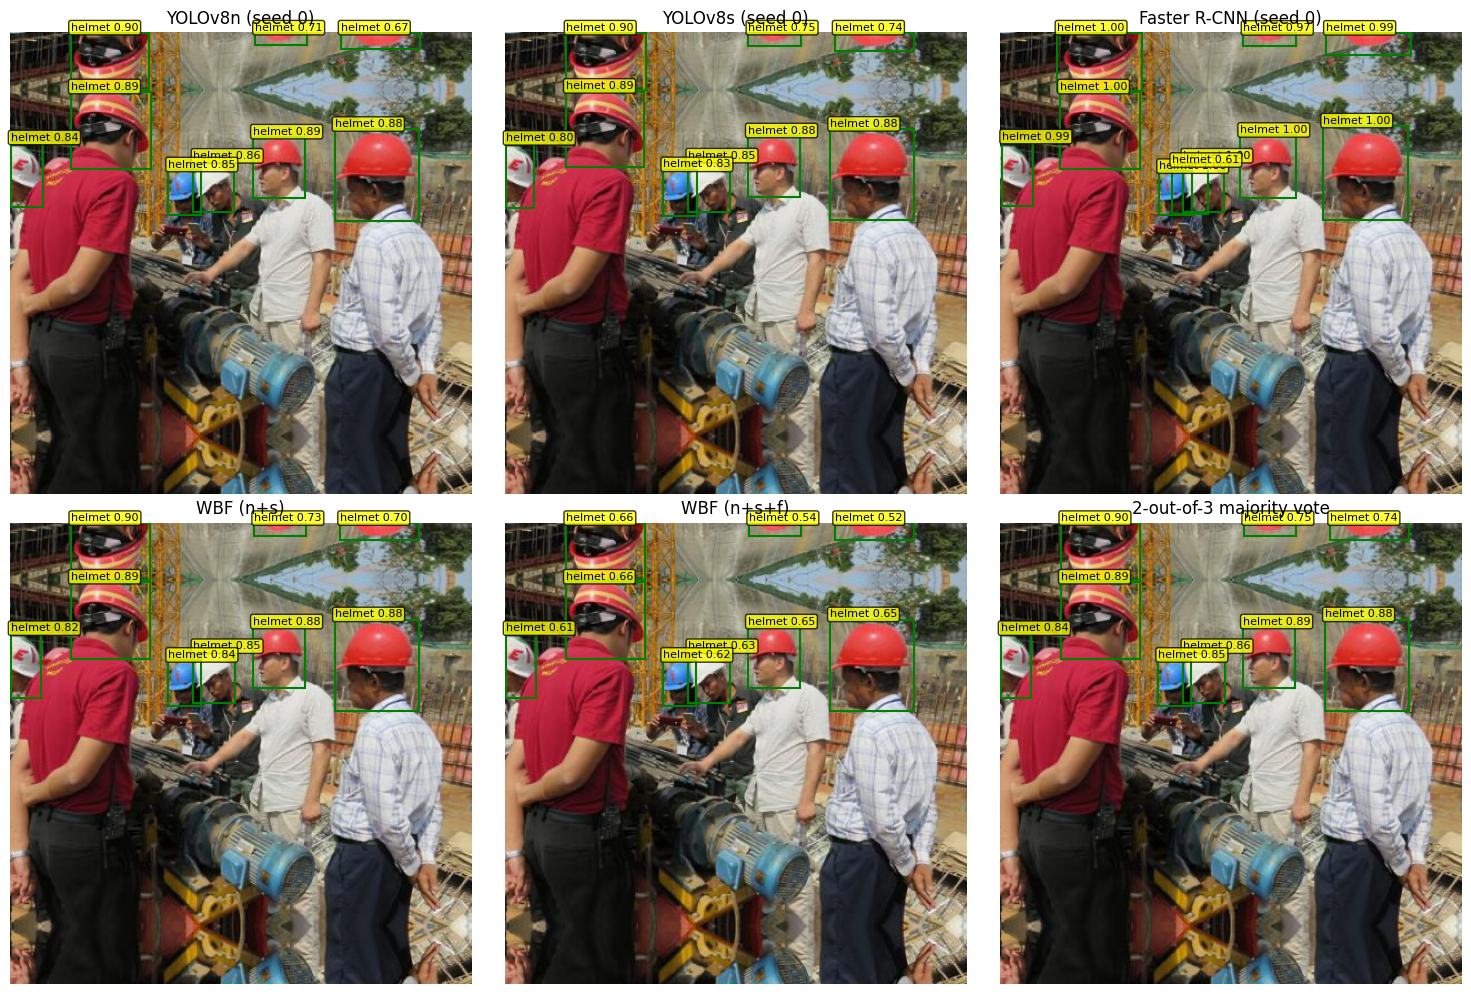

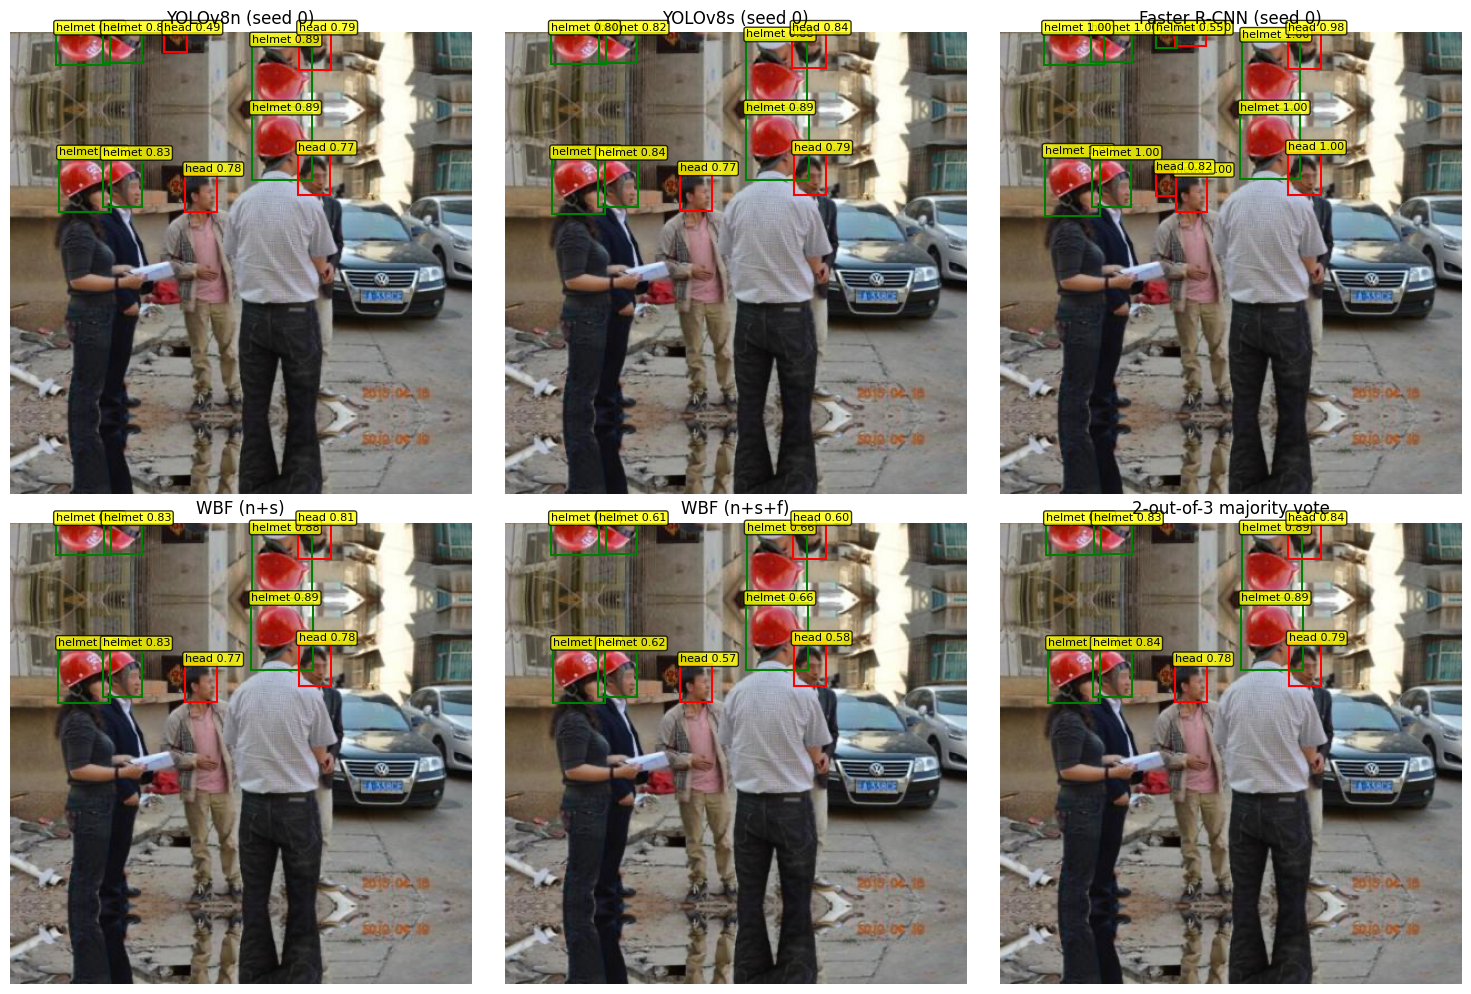

In [9]:
# One good example
show_all_methods_for_image("hard_hat_workers801", score_thresh=0.4)

# (Optional) more examples:
show_all_methods_for_image("hard_hat_workers830", score_thresh=0.4)
# show_all_methods_for_image("hard_hat_workers39", score_thresh=0.4)

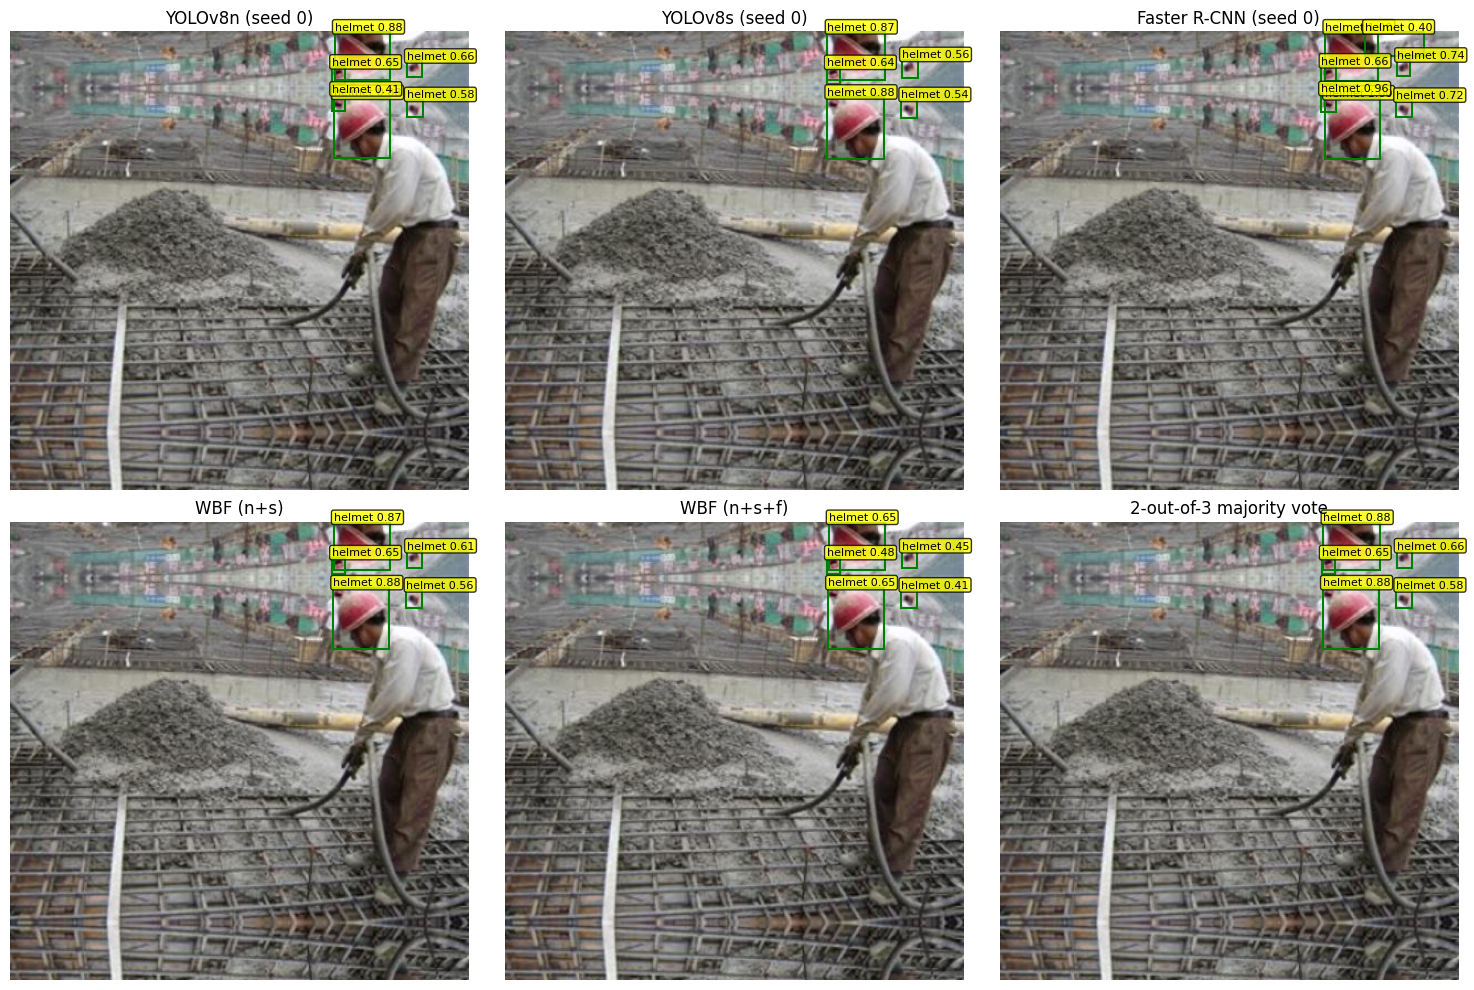

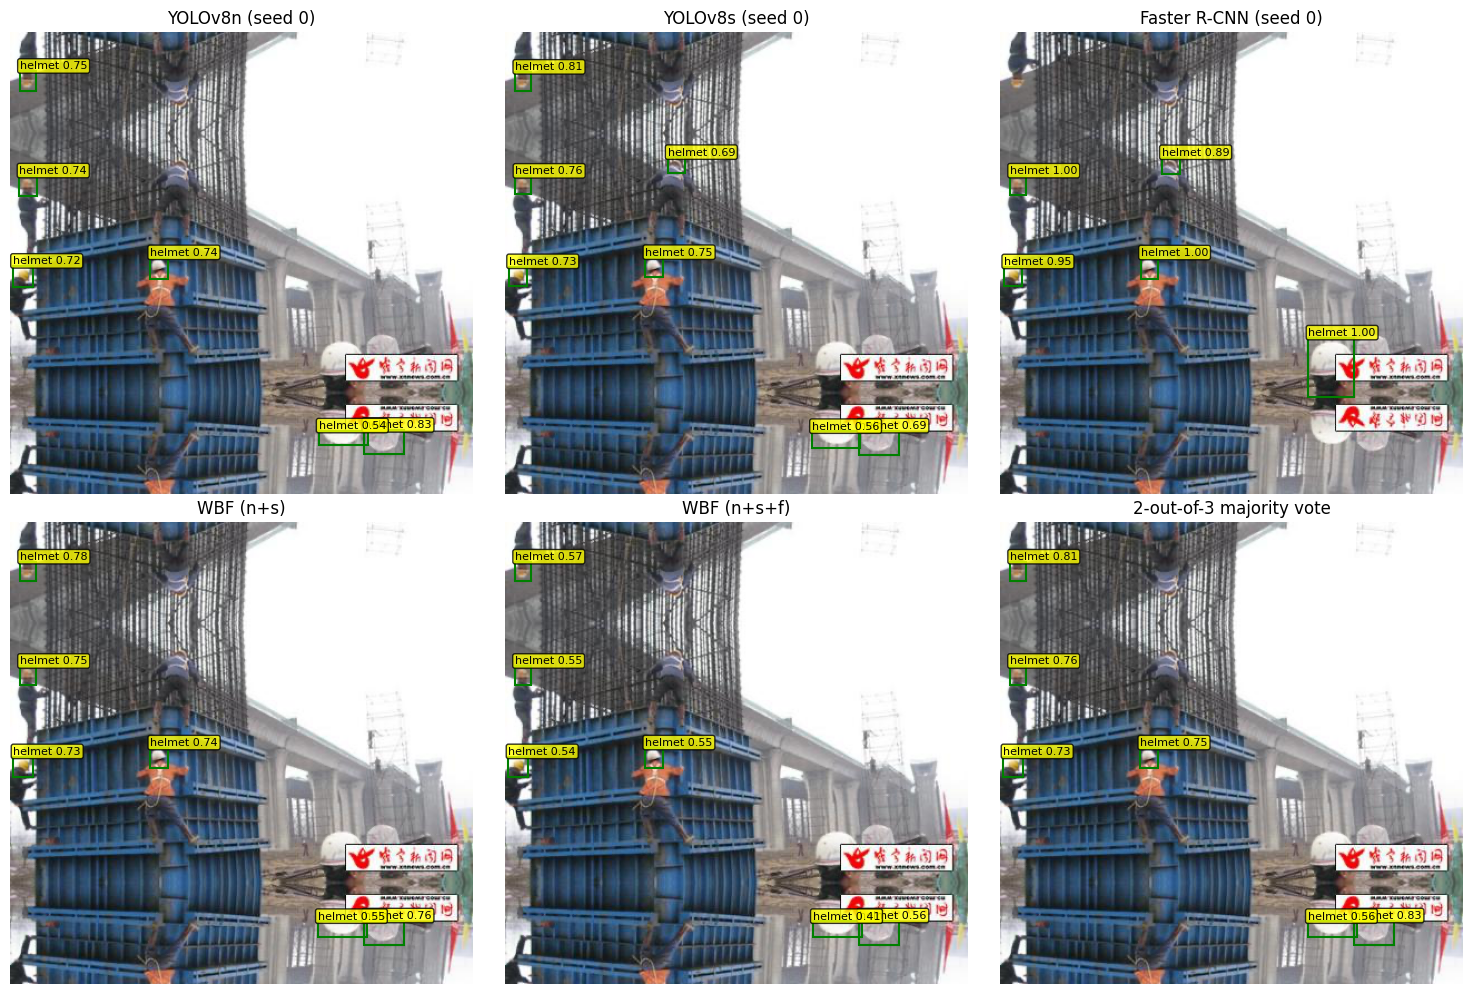

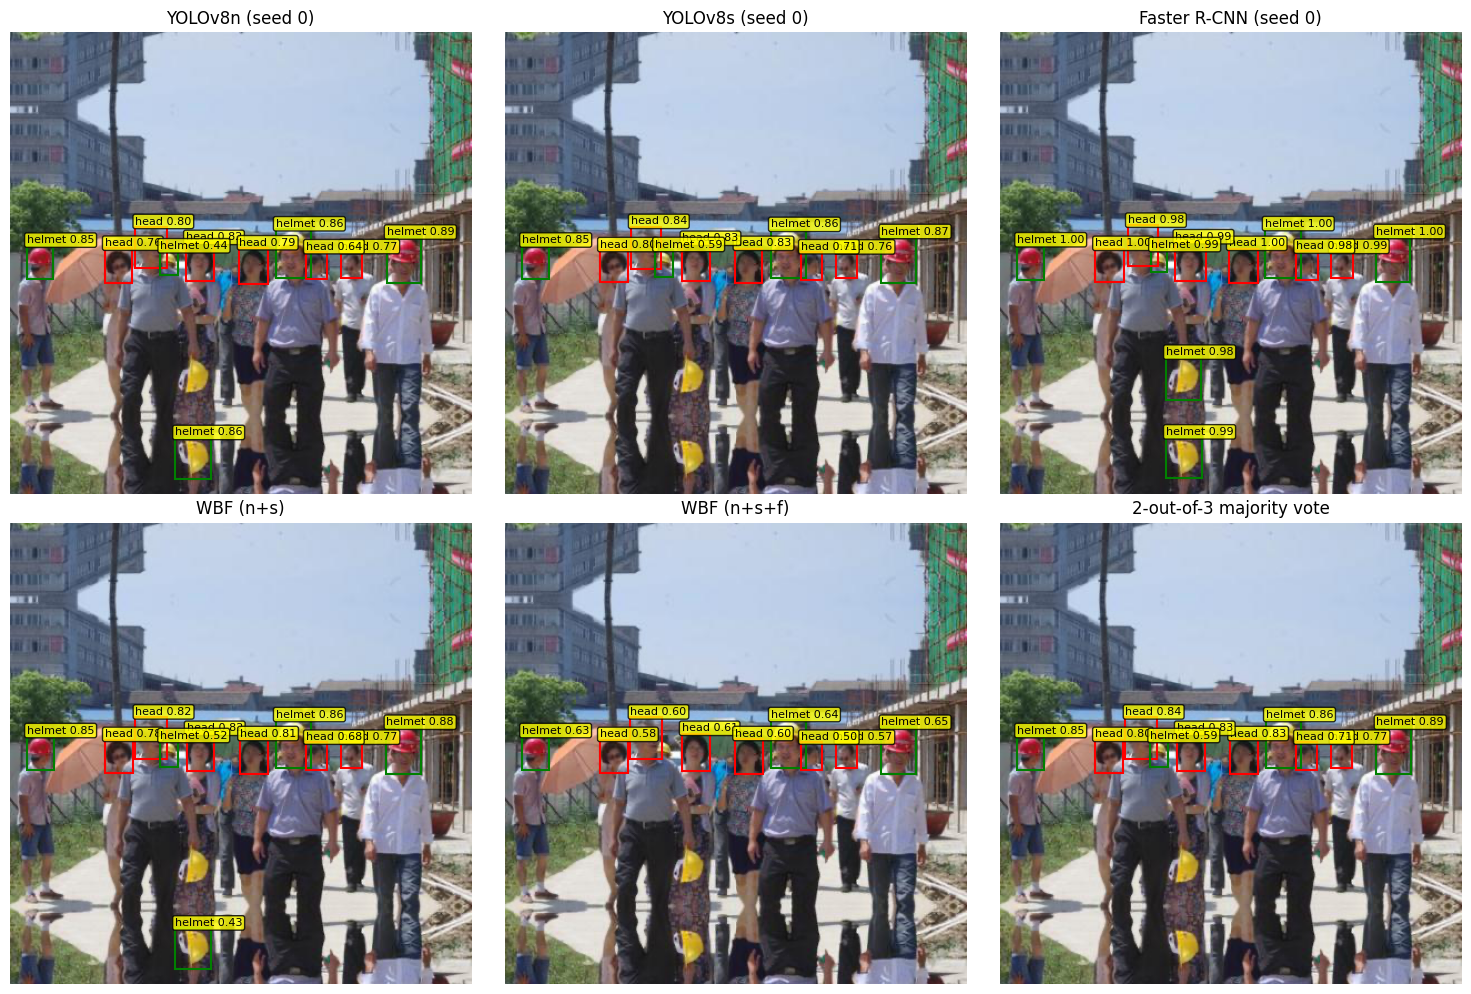

In [10]:
show_all_methods_for_image("hard_hat_workers852", score_thresh=0.4)
show_all_methods_for_image("hard_hat_workers475", score_thresh=0.4)
show_all_methods_for_image("hard_hat_workers863", score_thresh=0.4)

**GT loader + AP/mAP evaluator**

In [91]:
# Cell 10 – load GT from YOLO labels + mAP@0.5 evaluator

import os
import numpy as np
from pathlib import Path
from PIL import Image

# Make sure these exist; redefine if needed
VAL_IMAGES_DIR = DATA_ROOT / "val" / "images"
VAL_LABELS_DIR = DATA_ROOT / "val" / "labels"

def load_gt_yolo(val_labels_dir: Path):
    """
    Load ground-truth boxes from YOLO txt files (2 classes: 0=head, 1=helmet).
    Returns:
        gt[stem] = {
            "boxes":  np.array([[x1,y1,x2,y2], ...])  # normalized [0,1]
            "labels": np.array([...])                 # 0=head, 1=helmet
        }
    """
    gt = {}
    for label_path in sorted(val_labels_dir.glob("*.txt")):
        stem = label_path.stem
        boxes = []
        labels = []
        with open(label_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                cls, cx, cy, w, h = map(float, parts)
                cls = int(cls)
                # ignore old class-2 "person"
                if cls not in (0, 1):
                    continue
                x1 = cx - w / 2.0
                y1 = cy - h / 2.0
                x2 = cx + w / 2.0
                y2 = cy + h / 2.0
                boxes.append([x1, y1, x2, y2])
                labels.append(cls)
        if boxes:
            gt[stem] = {
                "boxes": np.array(boxes, dtype=float),
                "labels": np.array(labels, dtype=int),
            }
        else:
            gt[stem] = {
                "boxes": np.zeros((0, 4), dtype=float),
                "labels": np.zeros((0,), dtype=int),
            }
    return gt

def bbox_iou_single(pred_box, gt_boxes):
    """
    IoU between one box [4] and an array of boxes [N,4].
    All in normalized [0,1] xyxy.
    """
    if gt_boxes.size == 0:
        return np.zeros((0,), dtype=float)

    x1 = np.maximum(pred_box[0], gt_boxes[:, 0])
    y1 = np.maximum(pred_box[1], gt_boxes[:, 1])
    x2 = np.minimum(pred_box[2], gt_boxes[:, 2])
    y2 = np.minimum(pred_box[3], gt_boxes[:, 3])

    inter_w = np.clip(x2 - x1, 0, None)
    inter_h = np.clip(y2 - y1, 0, None)
    inter = inter_w * inter_h

    area_pred = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    area_gt   = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])

    union = area_pred + area_gt - inter + 1e-9
    return inter / union

def voc_ap(rec, prec):
    """
    Standard VOC-style AP from precision-recall curve.
    """
    mrec = np.concatenate(([0.0], rec, [1.0]))
    mpre = np.concatenate(([0.0], prec, [0.0]))

    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap

def compute_map_05(gt_dict, pred_dict, iou_thr=0.5, num_classes=2):
    """
    Compute mAP@0.5 over num_classes classes using a simple VOC-style evaluator.

    gt_dict[stem]   : {"boxes": [N_gt,4] normalized, "labels": [N_gt]}
    pred_dict[stem] : {"boxes": [N_pred,4] normalized, "labels": [N_pred], "scores": [N_pred]}
    """
    aps = {}
    # count GT per class
    npos = {c: 0 for c in range(num_classes)}
    for stem, g in gt_dict.items():
        labels = g["labels"]
        for c in range(num_classes):
            npos[c] += np.sum(labels == c)

    for c in range(num_classes):
        all_scores = []
        all_boxes = []
        all_img_ids = []

        # gather all predictions of this class
        for stem, p in pred_dict.items():
            labels_p = p["labels"]
            mask = labels_p == c
            if np.any(mask):
                boxes_c = p["boxes"][mask]
                scores_c = p["scores"][mask]
                for b, s in zip(boxes_c, scores_c):
                    all_boxes.append(b)
                    all_scores.append(s)
                    all_img_ids.append(stem)

        if len(all_scores) == 0 or npos[c] == 0:
            aps[c] = 0.0
            continue

        all_scores = np.array(all_scores)
        all_boxes = np.array(all_boxes)
        order = np.argsort(all_scores)[::-1]  # high -> low

        all_scores = all_scores[order]
        all_boxes = all_boxes[order]
        all_img_ids = [all_img_ids[i] for i in order]

        TP = np.zeros(len(all_scores))
        FP = np.zeros(len(all_scores))

        # per-image GT bookkeeping (which boxes already matched)
        gt_used = {}
        for stem, g in gt_dict.items():
            mask_c = g["labels"] == c
            gt_used[stem] = np.zeros(np.sum(mask_c), dtype=bool)

        for i, (stem, box_p) in enumerate(zip(all_img_ids, all_boxes)):
            g = gt_dict.get(stem, {"boxes": np.zeros((0, 4)), "labels": np.zeros((0,), int)})
            mask_c = g["labels"] == c
            gt_boxes_c = g["boxes"][mask_c]

            if gt_boxes_c.size == 0:
                FP[i] = 1
                continue

            ious = bbox_iou_single(box_p, gt_boxes_c)
            j = np.argmax(ious)
            if ious[j] >= iou_thr and not gt_used[stem][j]:
                TP[i] = 1
                gt_used[stem][j] = True
            else:
                FP[i] = 1

        TP = np.cumsum(TP)
        FP = np.cumsum(FP)
        recall = TP / (npos[c] + 1e-9)
        precision = TP / np.maximum(TP + FP, 1e-9)

        aps[c] = voc_ap(recall, precision)

    mAP = np.mean(list(aps.values()))
    return mAP, aps

# Load GT once
gt_val = load_gt_yolo(VAL_LABELS_DIR)
print("Loaded GT for", len(gt_val), "val images")

Loaded GT for 1000 val images


**WBF runner (with IoU parameter)**

In [92]:
# Cell 11 – run WBF for arbitrary IoU thresholds

!pip install -q ensemble-boxes
from ensemble_boxes import weighted_boxes_fusion

# list of all val image stems (we already built this earlier, but re-derive to be safe)
VAL_STEMS = [p.stem for p in sorted(VAL_IMAGES_DIR.glob("*.png"))]

def run_wbf_for_iou(pred_dicts, weights, iou_thr=0.55, skip_box_thr=0.001):
    """
    pred_dicts: list of per-image prediction dicts (like preds_y_n, preds_y_s, preds_frcnn)
    weights   : same length as pred_dicts
    Returns:
        fused[stem] = {"boxes": [N,4] normalized, "scores": [N], "labels": [N]}
    """
    fused = {}
    for stem in VAL_STEMS:
        boxes_list = []
        scores_list = []
        labels_list = []
        for preds in pred_dicts:
            if stem in preds:
                d = preds[stem]
                boxes_list.append(d["boxes"].tolist())
                scores_list.append(d["scores"].tolist())
                labels_list.append(d["labels"].tolist())
            else:
                boxes_list.append([])
                scores_list.append([])
                labels_list.append([])

        # if no boxes from any model -> empty
        if sum(len(b) for b in boxes_list) == 0:
            fused[stem] = {
                "boxes":  np.zeros((0, 4), dtype=float),
                "scores": np.zeros((0,), dtype=float),
                "labels": np.zeros((0,), dtype=int),
            }
            continue

        fb, fs, fl = weighted_boxes_fusion(
            boxes_list,
            scores_list,
            labels_list,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )

        fused[stem] = {
            "boxes":  np.array(fb, dtype=float),
            "scores": np.array(fs, dtype=float),
            "labels": np.array(fl, dtype=int),
        }

    return fused

**IoU sweep + print mAP**

In [93]:
#sweep WBF IoU thresholds and compute mAP@0.5

ious = [0.3, 0.4, 0.5, 0.55, 0.6, 0.7]
map_ns = []   # WBF(n+s)
map_nsf = []  # WBF(n+s+frcnn)

for iou in ious:
    fused_ns = run_wbf_for_iou(
        pred_dicts=[preds_y_n, preds_y_s],
        weights=[1.0, 1.0],
        iou_thr=iou,
    )
    m_ns, _ = compute_map_05(gt_val, fused_ns, iou_thr=0.5)
    map_ns.append(m_ns)

    fused_nsf = run_wbf_for_iou(
        pred_dicts=[preds_y_n, preds_y_s, preds_frcnn],
        weights=[1.0, 1.0, 0.7],
        iou_thr=iou,
    )
    m_nsf, _ = compute_map_05(gt_val, fused_nsf, iou_thr=0.5)
    map_nsf.append(m_nsf)

    print(f"IoU {iou:.2f}:  WBF(n+s) mAP@0.5 = {m_ns:.3f}   |   WBF(n+s+f) mAP@0.5 = {m_nsf:.3f}")

IoU 0.30:  WBF(n+s) mAP@0.5 = 0.921   |   WBF(n+s+f) mAP@0.5 = 0.939
IoU 0.40:  WBF(n+s) mAP@0.5 = 0.921   |   WBF(n+s+f) mAP@0.5 = 0.942
IoU 0.50:  WBF(n+s) mAP@0.5 = 0.922   |   WBF(n+s+f) mAP@0.5 = 0.942
IoU 0.55:  WBF(n+s) mAP@0.5 = 0.922   |   WBF(n+s+f) mAP@0.5 = 0.943
IoU 0.60:  WBF(n+s) mAP@0.5 = 0.922   |   WBF(n+s+f) mAP@0.5 = 0.943
IoU 0.70:  WBF(n+s) mAP@0.5 = 0.923   |   WBF(n+s+f) mAP@0.5 = 0.944


**Plot mAP vs IoU**

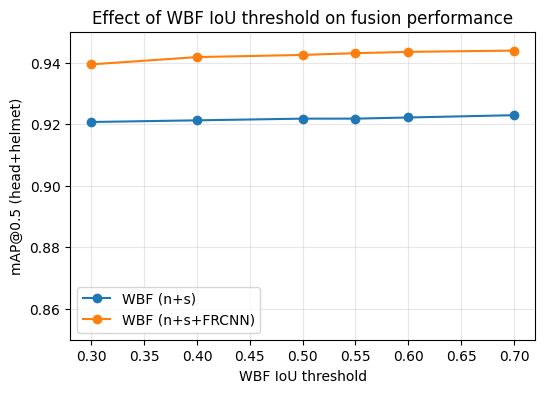

In [94]:
# Cell 13 – plot mAP vs WBF IoU threshold

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(ious, map_ns,  marker="o", label="WBF (n+s)")
plt.plot(ious, map_nsf, marker="o", label="WBF (n+s+FRCNN)")

plt.xlabel("WBF IoU threshold")
plt.ylabel("mAP@0.5 (head+helmet)")
plt.title("Effect of WBF IoU threshold on fusion performance")
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0.85, 0.95)  # adjust if needed depending on your numbers
plt.show()


What the IoU sweep shows

	•	For WBF(n+s):
	•	mAP@0.5 stays in a very narrow band: 0.921 → 0.923 as IoU goes from 0.30 to 0.70.
	•	For WBF(n+s+FRCNN):
	•	mAP@0.5 improves slightly from 0.939 (IoU=0.30) to about 0.944 (IoU=0.70).
	•	Fusion with FRCNN is consistently better than n+s alone at every IoU.

So WBF is quite robust to the IoU threshold in the range 0.3–0.7; performance is basically flat with a slight peak at the higher IoUs.

⸻

We swept the WBF IoU threshold from 0.30 to 0.70 using the same three detectors. For both WBF(n+s) and WBF(n+s+FRCNN), mAP@0.5 changes only very slightly (≈0.921→0.923 for n+s and 0.939→0.944 for n+s+FRCNN), indicating that the fusion is robust to the IoU hyperparameter. We kept IoU ≈ 0.55 as our default, which lies in the flat “good” region: low IoUs risk merging unrelated heads, while very high IoUs start to prevent beneficial fusion of slightly misaligned boxes.


#### Effect of WBF IoU threshold

We swept the WBF IoU threshold from 0.30 to 0.70 for both fusion variants:

- **WBF (n+s)**: mAP@0.5 stays almost constant, from **0.921 → 0.923**.
- **WBF (n+s+FRCNN)**: mAP@0.5 changes only slightly, from **0.939 → 0.944**.
- At every IoU, the 3-model fusion (n+s+FRCNN) is better than n+s alone.

**Takeaway:** WBF is quite robust to the IoU hyperparameter in this range.  
We keep **IoU = 0.55** as our default, which sits in the flat “good” region:  
- **Too low IoU (≈0.3)** can merge unrelated heads.  
- **Too high IoU (≈0.7)** starts to prevent beneficial fusion of slightly misaligned boxes.

In [86]:
import pandas as pd

METRICS_CSV = PROJECT_ROOT / "metrics_map_summary_nversion.csv"
df = pd.read_csv(METRICS_CSV)

print("Columns in metrics CSV:")
print(df.columns.tolist())
df.head()

Columns in metrics CSV:
['method', 'seed', 'corruption_type', 'level', 'mAP50_all', 'AP_head', 'AP_helmet', 'precision', 'recall']


method      seed     corruption_type     level  \
0              YOLOv8n_seed0  0.000000               clean  0.000000   
1              YOLOv8s_seed0  0.000000               clean  0.000000   
2           FasterRCNN_seed0  0.889315  0.6384369552576432  0.935305   
3        WBF_yolov8n_yolov8s  0.000000                 0.0  0.000000   
4  WBF_yolov8n_yolov8s_frcnn  0.000000                 0.0  0.000000   

     mAP50_all   AP_head  AP_helmet  precision    recall  
0     0.942693  0.610289   0.646382   0.928605  0.894928  
1     0.945763  0.614751   0.651707   0.935142  0.899294  
2  4699.000000  0.886200   0.892430        NaN       NaN  
3  4699.000000  0.000000   0.000000        NaN       NaN  
4  4699.000000  0.000000   0.000000        NaN       NaN

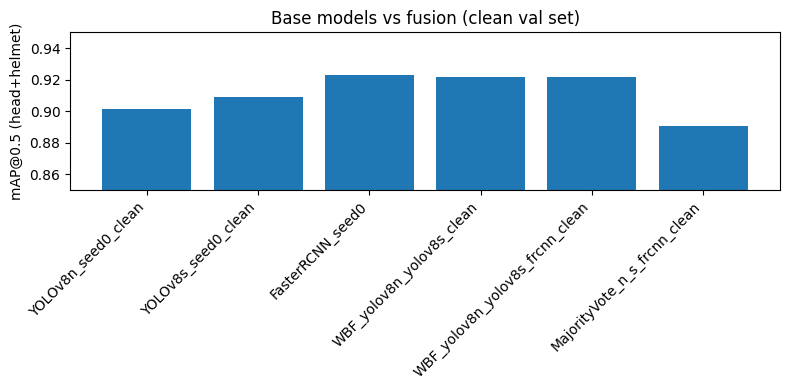

method     mAP50   AP_head  AP_helmet
12              YOLOv8n_seed0_clean  0.901140  0.875330   0.926950
13              YOLOv8s_seed0_clean  0.909283  0.885288   0.933278
11                 FasterRCNN_seed0  0.923214  0.899323   0.947105
14        WBF_yolov8n_yolov8s_clean  0.921642  0.897344   0.945941
15  WBF_yolov8n_yolov8s_frcnn_clean  0.921363  0.897615   0.945111
16     MajorityVote_n_s_frcnn_clean  0.890419  0.865194   0.915644

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

METRICS_CSV = PROJECT_ROOT / "metrics_map_summary_nversion.csv"
df = pd.read_csv(METRICS_CSV)

# Methods we care about
keep_methods = [
    "YOLOv8n_seed0_clean",
    "YOLOv8s_seed0_clean",
    "FasterRCNN_seed0",
    "WBF_yolov8n_yolov8s_clean",
    "WBF_yolov8n_yolov8s_frcnn_clean",
    "MajorityVote_n_s_frcnn_clean",
]

df_plot = df[df["method"].isin(keep_methods)].copy()

# --- compute mAP@0.5 from AP_head + AP_helmet ---
df_plot["mAP50"] = 0.5 * (df_plot["AP_head"] + df_plot["AP_helmet"])

# If there are multiple rows per method (e.g. FasterRCNN_seed0),
# keep the one with the highest mAP50
df_plot = (
    df_plot
    .sort_values(["method", "mAP50"], ascending=[True, False])
    .drop_duplicates(subset="method", keep="first")
)

# Order methods nicely
df_plot["method"] = pd.Categorical(
    df_plot["method"],
    categories=keep_methods,
    ordered=True,
)
df_plot = df_plot.sort_values("method")

# ---- Plot ----
plt.figure(figsize=(8, 4))
plt.bar(df_plot["method"], df_plot["mAP50"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("mAP@0.5 (head+helmet)")
plt.title("Base models vs fusion (clean val set)")
plt.ylim(0.85, 0.95)  # optional: zoom to see differences
plt.tight_layout()
plt.show()

# Small table for the report
cols_to_show = ["method", "mAP50", "AP_head", "AP_helmet"]
display(df_plot[cols_to_show])

Base models vs N-version fusion (clean validation set).
Our two YOLO models reach mAP@0.5 of 0.90–0.91, while Faster R-CNN is slightly stronger at 0.92.
Applying Weighted Boxes Fusion (WBF) to YOLOv8n+YOLOv8s, and to YOLOv8n+YOLOv8s+FRCNN, keeps mAP around 0.92, matching or slightly improving over the best single detector.
The 2-out-of-3 majority voter sacrifices some mAP (down to 0.89) but is designed for higher dependability, only keeping boxes where at least two models agree.

In [89]:
import pandas as pd

# Hand-written summary from our earlier evaluation (clean val set)
summary_rows = [
    # method,                     role,                 mAP50,   precision, recall
    ("WBF_yolov8n_yolov8s_frcnn_clean", "performance-oriented fusion", 0.921, 0.874, 0.947),
    ("MajorityVote_n_s_frcnn_clean",    "dependability-oriented voter", 0.890, 0.936, 0.914),
]

demo_df = pd.DataFrame(summary_rows,
                       columns=["method", "role", "mAP50", "precision", "recall"])
demo_df

method                          role  mAP50  \
0  WBF_yolov8n_yolov8s_frcnn_clean   performance-oriented fusion  0.921   
1     MajorityVote_n_s_frcnn_clean  dependability-oriented voter  0.890   

   precision  recall  
0      0.874   0.947  
1      0.936   0.914

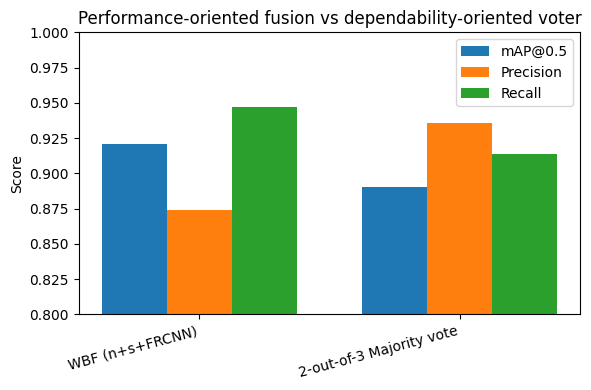

In [90]:
import matplotlib.pyplot as plt
import numpy as np

methods   = ["WBF (n+s+FRCNN)", "2-out-of-3 Majority vote"]
mAP50     = [0.921, 0.890]
precision = [0.874, 0.936]
recall    = [0.947, 0.914]

x = np.arange(len(methods))
width = 0.25

fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(x - width, mAP50,     width, label="mAP@0.5")
ax.bar(x,         precision, width, label="Precision")
ax.bar(x + width, recall,    width, label="Recall")

ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha="right")
ax.set_ylim(0.8, 1.0)
ax.set_ylabel("Score")
ax.set_title("Performance-oriented fusion vs dependability-oriented voter")
ax.legend()

plt.tight_layout()
plt.show()

We implemented a 3-version N-version system with YOLOv8n, YOLOv8s, and Faster R-CNN.
A performance-oriented fusion (Weighted Boxes Fusion over all three models) achieves the best overall detection quality with mAP@0.5 ≈ 0.92 and recall ≈ 0.95, but its precision is lower (≈ 0.87).
Our dependability-oriented configuration is a 2-out-of-3 majority voter on the same three models. It only accepts boxes where at least two detectors agree, which raises precision to ≈ 0.94 at the cost of some recall (≈ 0.91, mAP@0.5 ≈ 0.89).
This trade-off illustrates how N-version fusion can be tuned either for maximum detection performance or for more conservative, high-precision decisions in a safety-critical PPE monitoring setting.

---

---

#### Multi-seed experiments (planned but not fully executed)

We originally planned to retrain YOLOv8n and YOLOv8s with multiple seeds
(e.g., {0, 1, 42}) and report mean ± std mAP@0.5 across seeds, as well as
fusion performance using those different runs.

Due to limited GPU time and the cost of repeatedly training YOLO models,
we only carried out the **seed 0** runs for YOLOv8n, YOLOv8s and Faster R-CNN.
All fusion and voter results in this notebook are based on these seed 0 models.

Conceptually, the N-version architecture does not depend on the seed:
with more time/compute, we would repeat the same training with multiple seeds
and report variability, but the **design of the 3-version system + WBF + 2-out-of-3
voter would stay the same.**

-------

-------

-------

In [4]:
!pip install ultralytics ensemble-boxes opencv-python-headless torchvision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.3 MB/s eta 0:00:00


In [13]:
from pathlib import Path
import torch
from ultralytics import YOLO
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import cv2
import numpy as np
from ensemble_boxes import weighted_boxes_fusion

# --- Paths ---
PROJECT_ROOT = Path("/content/drive/MyDrive/CS6436_project")

YOLOV8N_WEIGHTS = PROJECT_ROOT / "hardhat_hh_2class" / "yolov8n_seed0" / "weights" / "best.pt"
YOLOV8S_WEIGHTS = PROJECT_ROOT / "hardhat_hh_2class" / "yolov8s_seed0" / "weights" / "best.pt"
FRCNN_WEIGHTS   = PROJECT_ROOT / "models" / "fasterrcnn_seed0_best.pth"

INPUT_VIDEO  = PROJECT_ROOT / "demo_site.mp4"
OUTPUT_VIDEO = PROJECT_ROOT / "demo_output_wbf_vs_mv.mp4"   # new name

print("YOLOv8n:", YOLOV8N_WEIGHTS.exists())
print("YOLOv8s:", YOLOV8S_WEIGHTS.exists())
print("FRCNN  :", FRCNN_WEIGHTS.exists())
print("Input video:", INPUT_VIDEO.exists())

assert YOLOV8N_WEIGHTS.exists(), "Missing YOLOv8n weights"
assert YOLOV8S_WEIGHTS.exists(), "Missing YOLOv8s weights"
assert FRCNN_WEIGHTS.exists(),   "Missing Faster R-CNN weights"
assert INPUT_VIDEO.exists(),     "Missing input video"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load YOLO models (2-class: 0=head, 1=helmet) ---
yolo_n = YOLO(str(YOLOV8N_WEIGHTS))
yolo_s = YOLO(str(YOLOV8S_WEIGHTS))

# --- Load Faster R-CNN model (3 classes: background, head, helmet) ---
num_classes = 3  # background + head + helmet

frcnn = fasterrcnn_resnet50_fpn(weights=None)  # backbone only
in_features = frcnn.roi_heads.box_predictor.cls_score.in_features
frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

state = torch.load(FRCNN_WEIGHTS, map_location="cpu")
frcnn.load_state_dict(state)
frcnn.to(device)
frcnn.eval()

YOLOv8n: True
YOLOv8s: True
FRCNN  : True
Input video: True
Using device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [14]:
import numpy as np
import cv2

CLASS_NAMES = {0: "head", 1: "helmet"}

def normalize_boxes_xyxy(boxes, w, h):
    """pixels xyxy -> normalized [0,1] xyxy"""
    if boxes is None or len(boxes) == 0:
        return np.zeros((0, 4), dtype=float)
    boxes = np.asarray(boxes, dtype=float).copy()
    boxes[:, [0, 2]] /= float(w)
    boxes[:, [1, 3]] /= float(h)
    return boxes

def denormalize_boxes_xyxy(boxes, w, h):
    """normalized [0,1] xyxy -> pixels xyxy"""
    if boxes is None or len(boxes) == 0:
        return np.zeros((0, 4), dtype=float)
    boxes = np.asarray(boxes, dtype=float).copy()
    boxes[:, [0, 2]] *= float(w)
    boxes[:, [1, 3]] *= float(h)
    return boxes

def draw_detections(img, boxes, labels, scores, title=None):
    """
    Draw red boxes for head (0), green boxes for helmet (1).
    img is BGR, modified in place.
    Also draws the title inside a black box at the top-left for readability.
    """
    out = img.copy()

    # ---- draw detections ----
    for (x1, y1, x2, y2), cls, score in zip(boxes, labels, scores):
        cls = int(cls)
        if cls == 0:      # head
            color = (0, 0, 255)   # red
            text = f"head {score:.2f}"
        elif cls == 1:    # helmet
            color = (0, 255, 0)   # green
            text = f"helmet {score:.2f}"
        else:
            continue

        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)
        cv2.putText(out, text, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

    # ---- draw title in a black box ----
    if title is not None:
        font        = cv2.FONT_HERSHEY_SIMPLEX
        font_scale  = 0.9
        thickness   = 2
        padding     = 8

        (tw, th), _ = cv2.getTextSize(title, font, font_scale, thickness)

        # top-left corner for the box
        x0, y0 = 5, 5
        x1, y1 = x0 + tw + 2 * padding, y0 + th + 2 * padding

        # filled black rectangle
        cv2.rectangle(out, (x0, y0), (x1, y1), (0, 0, 0), -1)

        # white text centered in the box (vertically)
        text_org = (x0 + padding, y0 + th + padding)
        cv2.putText(out, title, text_org, font,
                    font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

    return out

# ---------- IoU helper for majority vote ----------

def iou_single_to_many(box, boxes):
    """
    IoU between one box [x1,y1,x2,y2] and an array of boxes [N,4].
    All in the same coordinate system (normalized or pixels).
    """
    boxes = np.asarray(boxes, dtype=float)
    if boxes.size == 0:
        return np.zeros(0, dtype=float)

    box = np.asarray(box, dtype=float)

    x1 = np.maximum(box[0], boxes[:, 0])
    y1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[2], boxes[:, 2])
    y2 = np.minimum(box[3], boxes[:, 3])

    inter_w = np.maximum(0.0, x2 - x1)
    inter_h = np.maximum(0.0, y2 - y1)
    inter   = inter_w * inter_h

    area_box   = (box[2] - box[0]) * (box[3] - box[1])
    area_boxes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union      = area_box + area_boxes - inter + 1e-9

    return inter / union

# ---------- 2-out-of-3 majority vote on a frame ----------

def majority_vote_fusion_frame(boxes_list, scores_list, labels_list, iou_thr=0.55):
    """
    boxes_list  : [boxes_n, boxes_s, boxes_f]   each (Ni,4) normalized xyxy
    scores_list : [scores_n, scores_s, scores_f]
    labels_list : [labels_n, labels_s, labels_f]  labels in {0=head, 1=helmet}

    Returns fused_boxes, fused_labels, fused_scores in normalized xyxy.
    Keeps only clusters where >=2 distinct models contribute.
    """
    clusters = []  # each cluster: dict(boxes, scores, label, model_ids)

    # model_id: 0 = YOLOv8n, 1 = YOLOv8s, 2 = FRCNN
    for model_id, (boxes, scores, labels) in enumerate(
        zip(boxes_list, scores_list, labels_list)
    ):
        boxes  = np.asarray(boxes)
        scores = np.asarray(scores)
        labels = np.asarray(labels)

        if boxes.size == 0:
            continue

        for b, s, l in zip(boxes, scores, labels):
            b = np.asarray(b, dtype=float)
            l = int(l)
            assigned = False

            for cl in clusters:
                if cl["label"] != l:
                    continue
                existing_boxes = np.vstack(cl["boxes"])
                ious = iou_single_to_many(b, existing_boxes)
                if ious.size > 0 and ious.max() >= iou_thr:
                    cl["boxes"].append(b)
                    cl["scores"].append(float(s))
                    cl["model_ids"].add(model_id)
                    assigned = True
                    break

            if not assigned:
                clusters.append({
                    "boxes": [b],
                    "scores": [float(s)],
                    "label": l,
                    "model_ids": set([model_id]),
                })

    fused_boxes  = []
    fused_labels = []
    fused_scores = []

    for cl in clusters:
        # 2-out-of-3 condition: at least 2 distinct models contributed
        if len(cl["model_ids"]) < 2:
            continue

        boxes_arr  = np.vstack(cl["boxes"])
        scores_arr = np.array(cl["scores"], dtype=float)

        # score-weighted average of box coordinates
        w = scores_arr / (scores_arr.sum() + 1e-9)
        fused_box = (boxes_arr * w[:, None]).sum(axis=0)

        fused_score = float(scores_arr.max())
        fused_label = cl["label"]

        fused_boxes.append(fused_box)
        fused_scores.append(fused_score)
        fused_labels.append(fused_label)

    if len(fused_boxes) == 0:
        return (
            np.zeros((0, 4), dtype=float),
            np.zeros((0,), dtype=int),
            np.zeros((0,), dtype=float),
        )

    return (
        np.vstack(fused_boxes).astype(float),
        np.array(fused_labels, dtype=int),
        np.array(fused_scores, dtype=float),
    )

In [15]:
import cv2
import torch
import numpy as np

@torch.no_grad()
def run_frcnn_on_frame(frame_bgr, score_thresh=0.3):
    """
    Run Faster R-CNN on a single BGR frame.
    Returns pixel xyxy boxes, labels in {0,1}, scores.
    """
    h, w, _ = frame_bgr.shape

    # BGR -> RGB, and make a contiguous copy to avoid negative strides
    img_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb.copy()  # <- this removes negative strides

    img_tensor = torch.from_numpy(img_rgb).float() / 255.0
    img_tensor = img_tensor.permute(2, 0, 1)  # HWC -> CHW
    img_tensor = img_tensor.to(device)

    outputs = frcnn([img_tensor])[0]
    boxes = outputs["boxes"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()  # 1=head, 2=helmet

    # Confidence threshold
    keep = scores >= score_thresh
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    if len(boxes) == 0:
        return (
            np.zeros((0, 4), dtype=float),
            np.zeros((0,), dtype=int),
            np.zeros((0,), dtype=float),
        )

    # Map FRCNN labels {1,2} -> our labels {0,1}
    labels = labels - 1
    return boxes, labels, scores

In [16]:
score_thresh = 0.35   # detection threshold (same for all models)
iou_thr      = 0.55   # IoU for WBF and majority-vote clustering

cap = cv2.VideoCapture(str(INPUT_VIDEO))
if not cap.isOpened():
    raise RuntimeError("Could not open input video")

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output: side-by-side (WBF | Majority Vote)
out_w, out_h = 2 * w, h
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(str(OUTPUT_VIDEO), fourcc, fps, (out_w, out_h))

frame_idx = 0

def yolo_results_to_arrays(res, score_thresh=0.3):
    if res.boxes is None or len(res.boxes) == 0:
        return (
            np.zeros((0, 4), dtype=float),
            np.zeros((0,), dtype=int),
            np.zeros((0,), dtype=float),
        )
    boxes  = res.boxes.xyxy.cpu().numpy()
    scores = res.boxes.conf.cpu().numpy()
    labels = res.boxes.cls.cpu().numpy().astype(int)

    keep = scores >= score_thresh
    return boxes[keep], labels[keep], scores[keep]

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # --- YOLOv8n ---
    res_n = yolo_n.predict(source=frame, imgsz=640, conf=score_thresh, verbose=False)[0]
    boxes_n_px, labels_n, scores_n = yolo_results_to_arrays(res_n, score_thresh)

    # --- YOLOv8s ---
    res_s = yolo_s.predict(source=frame, imgsz=640, conf=score_thresh, verbose=False)[0]
    boxes_s_px, labels_s, scores_s = yolo_results_to_arrays(res_s, score_thresh)

    # --- Faster R-CNN ---
    boxes_f_px, labels_f, scores_f = run_frcnn_on_frame(frame, score_thresh=score_thresh)

    # --- Normalize all boxes to [0,1] for fusion ---
    boxes_n_norm = normalize_boxes_xyxy(boxes_n_px, w, h)
    boxes_s_norm = normalize_boxes_xyxy(boxes_s_px, w, h)
    boxes_f_norm = normalize_boxes_xyxy(boxes_f_px, w, h)

    # Package lists
    boxes_list  = [boxes_n_norm, boxes_s_norm, boxes_f_norm]
    scores_list = [scores_n,      scores_s,      scores_f]
    labels_list = [labels_n,      labels_s,      labels_f]

    # --- WBF(n+s+FRCNN) ---
    boxes_list_wbf  = [b.tolist() for b in boxes_list]
    scores_list_wbf = [s.tolist() for s in scores_list]
    labels_list_wbf = [l.tolist() for l in labels_list]

    boxes_wbf_norm, scores_wbf, labels_wbf = weighted_boxes_fusion(
        boxes_list_wbf,
        scores_list_wbf,
        labels_list_wbf,
        weights=[1.0, 1.0, 0.7],
        iou_thr=iou_thr,
        skip_box_thr=score_thresh,   # drop very low confidence
    )
    boxes_wbf_px = denormalize_boxes_xyxy(np.array(boxes_wbf_norm, dtype=float), w, h)
    scores_wbf   = np.array(scores_wbf, dtype=float)
    labels_wbf   = np.array(labels_wbf, dtype=int)

    # --- 2-out-of-3 Majority Vote ---
    boxes_mv_norm, labels_mv, scores_mv = majority_vote_fusion_frame(
        boxes_list, scores_list, labels_list, iou_thr=iou_thr
    )
    boxes_mv_px = denormalize_boxes_xyxy(boxes_mv_norm, w, h)

    # --- Draw overlays ---
    view_wbf = draw_detections(
        frame,
        boxes_wbf_px,
        labels_wbf,
        scores_wbf,
        title="WBF(n+s+FRCNN)"
    )
    view_mv = draw_detections(
        frame,
        boxes_mv_px,
        labels_mv,
        scores_mv,
        title="2-out-of-3 Majority Vote"
    )

    # Ensure shape consistency
    view_wbf = cv2.resize(view_wbf, (w, h))
    view_mv  = cv2.resize(view_mv,  (w, h))

    # Side-by-side
    combined = np.hstack([view_wbf, view_mv])
    out.write(combined)

    frame_idx += 1
    if frame_idx % 50 == 0:
        print(f"Processed {frame_idx} frames...")

cap.release()
out.release()
print(f"Done. Saved N-version demo video to: {OUTPUT_VIDEO}")

Processed 50 frames...
Processed 100 frames...
Processed 150 frames...
Done. Saved N-version demo video to: /content/drive/MyDrive/CS6436_project/demo_output_wbf_vs_mv.mp4
